In [31]:
import torch
import PIL
import numpy as np

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

## Data preparation for work with PyTorch

In [32]:
class CarDataset(Dataset):
    """
    A dataset with pictures, which parallel loads them from folders,
    scans and turns them into end tensors
    """
    def __init__(self, files):
        super().__init__()
        # file list for loading
        self.files = sorted(files)

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()
            
        # create label for image  
        self.labels = [ " ".join([path.parent.parent.name, path.parent.name]) for path in self.files]
        self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
              pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        # tarnsform image to pytorch tensor
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

In [33]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """
    Function for print image with their label
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [34]:
TRAIN_DIR = Path('av-photos')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [36]:
from sklearn.model_selection import train_test_split

train_val_labels = [ " ".join([path.parent.parent.name, path.parent.name]) for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [37]:
val_dataset = CarDataset(val_files)

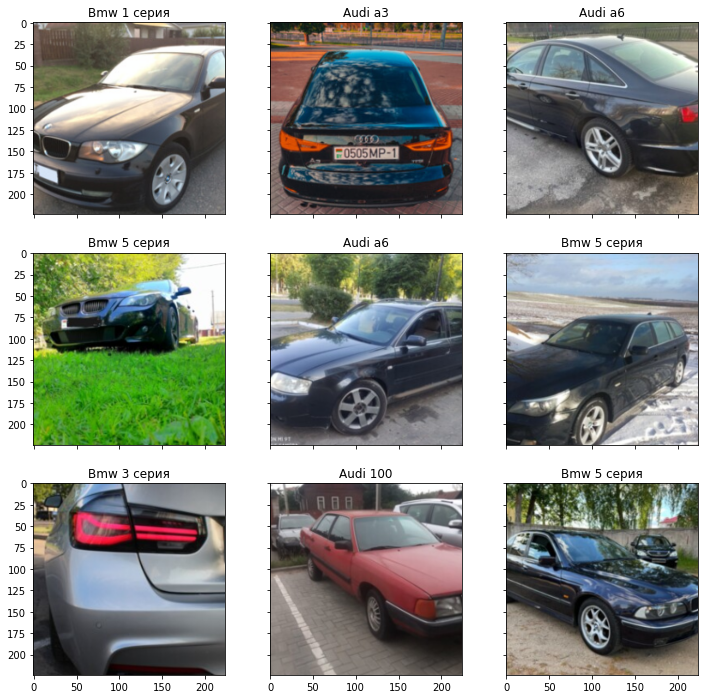

In [51]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)